In [1982]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
import os
from sklearn.metrics import mean_squared_error
from datetime import date
import time
import matplotlib.pylab as plt
%matplotlib inline

In [1983]:
class DataLoader():
    """
        DataLoader: Load the two data files into memory ready for cleaning and then merging
        - Final dataset is US-specific, two date columns for looking at weekly information pertaining to a particular region
    """

    dailyData = None
    weeklyData = None
    aggregateWeeklyData = None
    
    def divByMedian(self, x, medians):
        num_cols = self.aggregateWeeklyData.dtypes[self.aggregateWeeklyData.dtypes == 'float64'].index.tolist()
        for col in num_cols:
            if col != 'hospitalized_new' and col != 'hospitalized_cumulative':
                x[col] = x[col] / medians[x['sub_region_1']]
        return x
    
    def normalizeSymptomsByRegionMedian(self):
        
        medians = self.aggregateWeeklyData.groupby("sub_region_1").median().iloc[:,:-2].median(axis=1)
        self.aggregateWeeklyData.iloc[:, 3:-3] = self.aggregateWeeklyData.iloc[:,:-3].apply(lambda x: self.divByMedian(x, medians), axis=1).iloc[:,3:]
        display (self.aggregateWeeklyData)
        
    def generateDataSet(self):
        """
            generateDataSet: Generate final dataset by merging weeklySymptomData & weeklyHospitaliationData, based on sub_region_1
        """

        '''
        We want to see how symptoms aggregated across various Regions change over a Weekly time frame
        To do this, we merge the two dataframes based on geographical location, we have two date variables at the moment 
        '''
        self.aggregateWeeklyData = pd.merge(self.weeklySymptomData, self.weeklyHospitaliationData, how='inner', 
                                            left_on=['sub_region_1', 'date_symptoms'], right_on=['sub_region_1', 'date_hospitalization'])
        #replace NaN with avg value of column
        num_cols = self.aggregateWeeklyData.dtypes[self.aggregateWeeklyData.dtypes == 'float64'].index.tolist()
        for col in num_cols:
            self.aggregateWeeklyData[col].fillna(self.aggregateWeeklyData[col].mean(), inplace=True)
        
#         self.aggregateWeeklyData.drop(columns=["symptom:Trichoptilosis", "symptom:Angular cheilitis",
#                                                "symptom:Amenorrhea", "symptom:Allergic conjunctivitis",
#                                                "symptom:Urethritis",
#                                                "symptom:Urinary urgency", "symptom:Auditory hallucination",
#                                                "symptom:Balance disorder", "symptom:Beau's lines",
#                                                "symptom:Burning Chest Pain", "symptom:Cataplexy",
#                                                "symptom:Chorea", "symptom:Cleft lip and cleft palate",
#                                                "symptom:Clouding of consciousness", "symptom:Crepitus",
#                                                "symptom:Depersonalization", "symptom:Dysautonomia",
#                                                "symptom:Dyspareunia", "symptom:Dystonia",
#                                                "symptom:Dysuria", "symptom:Epiphora",
#                                                "symptom:Eye pain", "symptom:Facial swelling",
#                                                "symptom:Fibrocystic breast changes", "symptom:Focal seizure",
#                                                "symptom:Gastroparesis", "symptom:Gingival recession",
#                                                "symptom:Grandiosity", "symptom:Hemolysis",
#                                                "symptom:Hepatic encephalopathy", "symptom:Hepatotoxicity",
#                                                "symptom:Hydrocephalus", "symptom:Hypercalcaemia",
#                                                "symptom:Hyperemesis gravidarum", "symptom:Hypocalcaemia",
#                                                "symptom:Hypochondriasis", "symptom:Hypomania",
#                                                "symptom:Kyphosis", "symptom:Male infertility",
#                                                "symptom:Mitral insufficiency", "symptom:Myoclonus",
#                                                "symptom:Night terror", "symptom:Nocturnal enuresis",
#                                                "symptom:Nystagmus", "symptom:Onychorrhexis",
#                                                "symptom:Osteophyte", "symptom:Papule",
#                                                "symptom:Pericarditis", "symptom:Petechia",
#                                                "symptom:Photodermatitis", "symptom:Photophobia",
#                                                "symptom:Polydipsia", "symptom:Polyuria",
#                                                "symptom:Ptosis", "symptom:Rectal pain",
#                                                "symptom:Rectal prolapse", "symptom:Rumination",
#                                                "symptom:Sensitivity to sound", "symptom:Spasticity",
#                                                "symptom:Splenomegaly", "symptom:Stomach rumble",
#                                                "symptom:Subdural hematoma"], inplace=True)
        
        #normalize symptoms by regions median to make comparable across regions
        self.normalizeSymptomsByRegionMedian()
  
        return self.aggregateWeeklyData

    def cleanWeeklyAndDailyData(self):
        """
            cleanWeeklyAndDailyData: Remove empty values in the two dataframes, within respective bounds
        """
        
        '''
        weeklyData:
        - Drop all columns in weeklyData with more than 25 percent NaN values in a particular column
        - Drop all rows in weeklyData with more than 5 percent NaN values in a particular row
        - Rename Date column for distinction
        '''
        self.weeklyData.drop_duplicates(inplace=True)
        self.weeklyData.dropna(thresh=int(self.weeklyData.shape[0] * 0.25), inplace=True, axis='columns')
        self.weeklyData.dropna(thresh=int(self.weeklyData.shape[0] * 0.05), inplace=True, axis='index')   

        columnsToRemove = ['country_region_code', 'country_region', 'sub_region_1_code']
        self.weeklyData = self.weeklyData.drop(labels=columnsToRemove, axis='columns')

        self.weeklyData['date'] = self.weeklyData['date'].astype('datetime64[ns]')
        self.weeklyData.rename(columns={'date':'date_symptoms'}, inplace=True)

        '''
        dailyData:
        - Drop all columns in dailyData with more than 20 percent NaN values in a particular column
        - Drop all columns in dailyData of little-to-no interest
        - Rename Date column for distinction, rename region_name to match self.weeklyData.sub_region_1, before merging
        '''
        self.dailyData.dropna(thresh=int(self.dailyData.shape[0] * 0.2), inplace=True, axis='columns')
        self.dailyData = self.dailyData.get(['date', 'open_covid_region_code', 'region_name', 'hospitalized_new', 'hospitalized_cumulative'])
        self.dailyData.rename(columns={'region_name':'sub_region_1', 'date':'date_hospitalization'}, inplace=True)
        
        '''
        Iterate over the regions to discover the distinct 56 US States we want to analyze
        USRegionsList : List
        '''
        US_Regions_List = []
        for regionCode in self.dailyData['open_covid_region_code']:
            if ('US-' in regionCode and regionCode not in US_Regions_List):
                US_Regions_List.append(regionCode)

        '''
        Create a new dataframe subset (collection of rows) for a particular region
        Do this repeatedly to build a US_Daily_Table
        US_Daily_Table : DataFrame
        '''
        US_Daily_Table = None
        for US_Region in US_Regions_List:
            US_Region_Rows = self.dailyData.loc[self.dailyData['open_covid_region_code'] == US_Region]
            US_Daily_Table = pd.concat([US_Daily_Table, US_Region_Rows])
        
        '''
        Filter the above dataframe for non-zero values concerning the two hospitalization columns
        Populate self.dailyData with this new valid information
        '''
        indexNames = US_Daily_Table[(US_Daily_Table['hospitalized_new'] == 0.0) & (US_Daily_Table['hospitalized_cumulative'] == 0.0)].index
        US_Daily_Table.drop(indexNames, inplace=True)

        '''
        Convert daily dataframe into weekly, sorted alphabetically by region_name
        '''
        US_Daily_Table['date_hospitalization'] = US_Daily_Table['date_hospitalization'].astype('datetime64[ns]')
        US_Weekly_Table = US_Daily_Table.groupby("sub_region_1").resample('W-Mon', on='date_hospitalization').sum().reset_index()
        
        '''
        Set ptrs accordingly
        '''
        self.weeklySymptomData = self.weeklyData                            # Matrix ~ (312, 96)
        self.weeklyHospitaliationData = US_Weekly_Table                     # Matrix ~ (1052, 4)
        
        
    def loadRawData(self):
        """
            loadRawData: Init pandas dataframe for the two data files found within the data directory 
        Returns:
            DataFrame, DataFrame: Two pandas dataframe objects, one for each file 
        """
        dirname = os.getcwd()
        filename1 = os.path.join(dirname, '2020_US_weekly_symptoms_dataset.csv')
        filename2 = os.path.join(dirname, 'aggregated_cc_by.csv')
        DataSet1 = pd.read_csv(filename1, delimiter=',', dtype={"tests_new": float, "test_units": "string"})
        DataSet2 = pd.read_csv(filename2, delimiter=',', dtype={"tests_new": float, "test_units": "string"})
        return DataSet1, DataSet2

    def __init__(self) -> None:
        self.weeklyData, self.dailyData = self.loadRawData()
        self.cleanWeeklyAndDailyData()
        outputDataFrame = self.generateDataSet()
        # print(outputDataFrame)

dl = DataLoader()


,open_covid_region_code,sub_region_1,date_symptoms,symptom:Adrenal crisis,symptom:Ageusia,symptom:Allergic conjunctivitis,symptom:Amenorrhea,symptom:Angular cheilitis,symptom:Anosmia,symptom:Aphonia,...,symptom:Tenderness,symptom:Thyroid nodule,symptom:Trichoptilosis,symptom:Urethritis,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,date_hospitalization,hospitalized_new,hospitalized_cumulative
0,US-AK,Alaska,2020-03-30,0.997773,0.997773,0.791759,0.949889,0.706594,2.121381,0.673552,...,1.108018,1.044543,1.646993,1.092428,0.886414,0.791759,0.982183,2020-03-30,7.0,25.0
1,US-AK,Alaska,2020-04-06,1.122494,0.818486,0.827039,1.202673,0.786192,0.753898,0.673552,...,1.026726,0.962138,1.540089,1.122494,0.769599,0.817372,1.010022,2020-04-06,16.0,99.0
2,US-AK,Alaska,2020-04-13,0.694878,1.264857,0.827039,0.884187,0.726058,1.184855,0.673552,...,1.248330,1.594655,1.437639,0.932071,0.769599,0.817372,0.810427,2020-04-13,9.0,199.0
3,US-AK,Alaska,2020-04-20,0.824053,1.264857,0.694878,1.325167,0.706594,1.470947,0.673552,...,1.681514,1.115813,1.099109,1.131403,0.769599,1.002227,0.810427,2020-04-20,4.0,245.0
4,US-AK,Alaska,2020-04-27,0.995546,0.663697,0.827039,1.161470,0.706594,0.928731,0.673552,...,1.360802,1.659243,1.344098,1.243875,0.779510,1.094655,0.810427,2020-04-27,-36.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,US-WY,Wyoming,2020-08-31,1.370572,0.760218,2.023655,1.141689,1.728940,3.599212,1.648093,...,0.836512,0.836512,0.700272,2.327125,1.883106,2.000000,1.983006,2020-08-31,4.0,1501.0
118,US-WY,Wyoming,2020-09-07,0.915531,0.885559,0.599455,2.714013,0.613079,0.735695,1.648093,...,1.168937,0.765668,2.451171,0.869210,1.883106,2.000000,1.983006,2020-09-07,4.0,1547.0
119,US-WY,Wyoming,2020-09-14,1.130790,1.354223,2.023655,1.577657,1.728940,1.250681,1.648093,...,1.070845,1.534060,0.833787,0.877384,0.730245,2.000000,1.983006,2020-09-14,11.0,1636.0
120,US-WY,Wyoming,2020-09-21,1.536785,1.000000,2.023655,1.027248,1.728940,1.386921,1.648093,...,0.893733,1.013624,0.863760,0.790191,1.883106,0.880109,1.983006,2020-09-21,17.0,1673.0


# 2.1

In [1984]:
# Creating symptomData series and hospitalizationData series
symptomData = dl.aggregateWeeklyData.copy()
hospitalizationData = symptomData[['date_hospitalization', 'hospitalized_new']]
symptomData.drop(columns=['date_hospitalization', 'hospitalized_new', 'hospitalized_cumulative'], inplace=True)


In [1985]:
#Choosing top 3 symptoms based on their mean.  Excluding Photodermatitis due to too many NaN values.

symptomData.mean(axis = 0, skipna = True).sort_values(ascending=False)


symptom:Photodermatitis      2.219629
symptom:Asphyxia             1.656702
symptom:Anosmia              1.561259
symptom:Ageusia              1.402517
symptom:Chorea               1.357772
                               ...   
symptom:Angular cheilitis    0.868422
symptom:Aphonia              0.846007
symptom:Laryngitis           0.842517
symptom:Shallow breathing    0.841026
symptom:Polydipsia           0.807802
Length: 93, dtype: float64

In [1986]:
symptomData.var(axis=0).sort_values(ascending=False)

symptom:Asphyxia                      2.968709
symptom:Photodermatitis               1.403563
symptom:Anosmia                       0.774548
symptom:Ageusia                       0.562219
symptom:Chorea                        0.516898
                                        ...   
symptom:Tenderness                    0.058266
symptom:Gastroparesis                 0.058249
symptom:Fibrocystic breast changes    0.046799
symptom:Male infertility              0.040930
symptom:Focal seizure                 0.040802
Length: 93, dtype: float64

In [1987]:
symptomData.median(axis=0).sort_values(ascending=False)

symptom:Photodermatitis       1.968897
symptom:Nocturnal enuresis    1.340639
symptom:Dystonia              1.313087
symptom:Anosmia               1.310903
symptom:Neutropenia           1.284079
                                ...   
symptom:Angular cheilitis     0.689568
symptom:Laryngitis            0.686430
symptom:Shallow breathing     0.682358
symptom:Aphonia               0.673552
symptom:Polydipsia            0.652473
Length: 93, dtype: float64

In [1988]:
import pandas as pd
import seaborn as sns

#Creating heatmaps for Photodermatitis, Asphyxia, Anosmia and Ageusia
symptomData2 = symptomData
#Removing Vermont and Alaska due to lack of data for these symptoms
symptomData = symptomData[symptomData["sub_region_1"] != 'Vermont']
symptomData = symptomData[symptomData["sub_region_1"] != 'Alaska']


In [1989]:
#renaming columns for heatmap
mapping = {symptomData.columns[2]:'Date', symptomData.columns[1]: 'Region'}
symptomData = symptomData.rename(columns=mapping)

mappingHospitalization = {hospitalizationData.columns[0]:'Date', hospitalizationData.columns[1]: 'New hospitalizations'}
hospitalizationData = hospitalizationData.rename(columns=mappingHospitalization)


In [1990]:
#Changing date to string for formatting purposes on heatmap
symptomData['Date'] = symptomData.Date.astype('string')
hospitalizationData['Date'] = hospitalizationData.Date.astype('string')

#Creating pivot tables for each top symptom based on region and date
heatmap_photodermatitis = pd.pivot_table(symptomData, values='symptom:Photodermatitis', 
                     index=['Region'], 
                     columns= 'Date')


heatmap_asphyxia = pd.pivot_table(symptomData, values='symptom:Asphyxia', 
                     index=['Region'], 
                     columns='Date')

heatmap_anosmia = pd.pivot_table(symptomData, values='symptom:Anosmia', 
                     index=['Region'], 
                     columns='Date')

heatmap_ageusia = pd.pivot_table(symptomData, values='symptom:Ageusia', 
                     index=['Region'], 
                     columns='Date')

heatmap_hospitalizations = pd.pivot_table(hospitalizationData, values='New hospitalizations', 
                     columns='Date', aggfunc=np.sum)



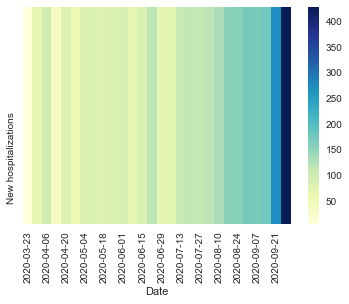

In [1991]:
sns.heatmap(heatmap_hospitalizations, cmap="YlGnBu")

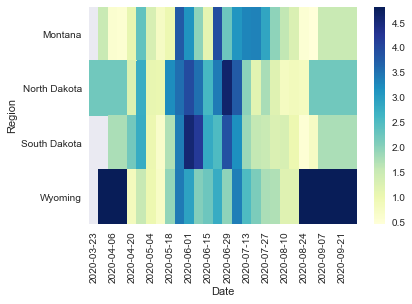

In [1992]:
sns.heatmap(heatmap_photodermatitis, cmap="YlGnBu")

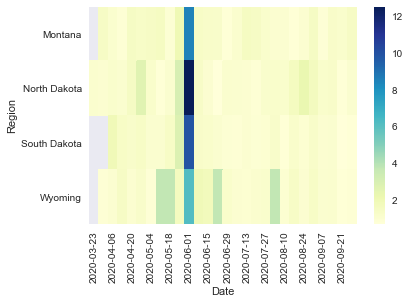

In [1993]:
sns.heatmap(heatmap_asphyxia, cmap="YlGnBu")

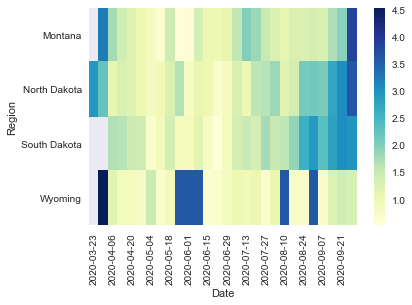

In [1994]:
sns.heatmap(heatmap_anosmia, cmap="YlGnBu")

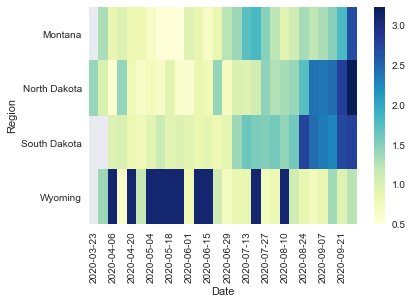

In [1995]:
sns.heatmap(heatmap_ageusia, cmap="YlGnBu")

# 2.2

In [1996]:
# Grouping rows with common dates in order to have a datapoint for each time point.
symptomDataMerged = symptomData2.drop(['open_covid_region_code', 'sub_region_1'], axis=1)
symptomDataMerged.groupby("date_symptoms").mean().iloc[:,:]
symptomDataMerged = symptomDataMerged.drop(['date_symptoms'], axis=1)

Text(0.5, 1.0, 'Variance Explained vs Principal Components')

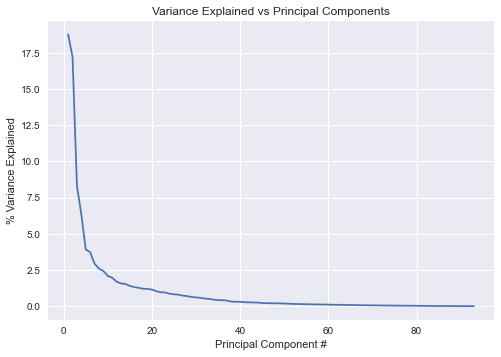

In [1997]:
# Looking at variance by each component to determined the top principal components having the most variance.
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
plt.style.use('seaborn')

X = symptomDataMerged

pca_a = PCA()
pca_a.fit(X)

pc_components_count = len(pca_a.explained_variance_ratio_)
plt.subplot(1,1,1)
plt.plot(np.linspace(1, pc_components_count, pc_components_count), 100*pca_a.explained_variance_ratio_)

plt.xlabel("Principal Component #")
plt.ylabel("% Variance Explained")
plt.title("Variance Explained vs Principal Components")


Text(0.5, 1.0, 'Principal components')

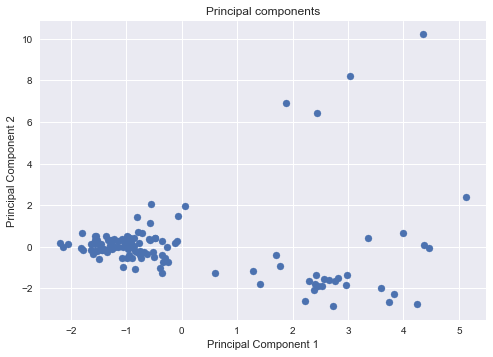

In [1998]:
#Based on knee rule, we will use 4 principle components
pca = PCA(n_components=4)
pca.fit(X)
X_low = pca.transform(X)

# Plotting the top 2 principal components.  Hence, dataset with reduced dimensions

plt.scatter(X_low[:,0], X_low[:,1])
plt.clim(-0.5,2.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('Principal components')


# 2.3

Text(0.5, 1.0, 'High-dimensional clustering with KMeans')

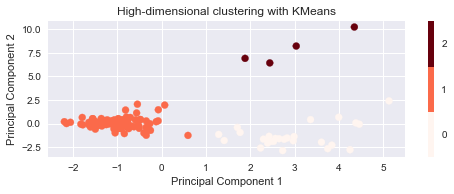

In [1965]:
#k-means clustering with high and low dimensional datasets
#Chosen 3 clusters based on visual inference

from sklearn.cluster import KMeans

kmeans_normal = KMeans(n_clusters=3, random_state=0)
kmeans_normal.fit(X)
normal_prediction = kmeans_normal.predict(X)

kmeans_low = KMeans(n_clusters=3, random_state=0)
kmeans_low.fit(X_low)
low_prediction = kmeans_low.predict(X_low)

# Plot 2 scatter plots -- two for high and low dimensional clustering results

#Scatterplot for clustering with reduced dimensions dataset

plt.subplot(2,1,1)
plt.scatter(X_low[:,0], X_low[:,1], c=normal_prediction, cmap=plt.cm.get_cmap('Reds',3))
plt.colorbar(ticks=[0,1,2])
plt.clim(-0.5,2.5)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("High-dimensional clustering with KMeans")

Text(0.5, 1.0, 'Low-dimensional clustering with KMeans')

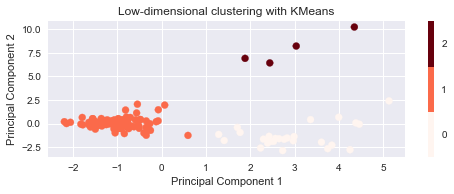

In [1966]:
#Scatterplot for low dimensional clustering

plt.subplot(2,1,2)
plt.scatter(X_low[:,0], X_low[:,1], c=low_prediction, cmap=plt.cm.get_cmap('Reds',3))
plt.colorbar(ticks=[0,1,2])
plt.clim(-0.5,2.5)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Low-dimensional clustering with KMeans")

In [1967]:
class Cross_Validation:
    def cross_validate_regions(self, data, k, model):
        regions = pd.Series(data["sub_region_1"].unique())
        
        shuffled_regions = regions.sample(frac=1, random_state=0).reset_index(drop=True)
            
        split_regions = np.array_split(shuffled_regions, k)
        
        folds = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
     
        for i in range(k):
            for region in split_regions[i]:
                matched = data.loc[lambda data: data["sub_region_1"] == region]
                folds[i] = folds[i].append(matched)
        
        
        for i in range(k):
            folds[i].drop(columns=["sub_region_1", "date_symptoms",
                                   "date_hospitalization", "open_covid_region_code"], inplace=True)
        
        error_sum = 0
        
        for i in range(k):
            folds_to_train = folds.copy()
            fold_to_test = folds_to_train[i]
            del folds_to_train[i]
            folds_to_train = pd.concat(folds_to_train, sort=False)
            
            x_train = folds_to_train.loc[:,folds_to_train.columns != "hospitalized_new"]
            y_train = folds_to_train.loc[:,folds_to_train.columns == "hospitalized_new"]
            
            x_test = fold_to_test.loc[:,fold_to_test.columns != "hospitalized_new"]
            y_test = fold_to_test.loc[:,fold_to_test.columns == "hospitalized_new"]
            
            model.fit(x_train, y_train.values.ravel())
            predictions = model.predict(x_test)
            error_sum += mean_squared_error(predictions, y_test)
            
        return error_sum / k


In [1968]:
cross = Cross_Validation()
data = dl.aggregateWeeklyData
print (data)

    open_covid_region_code sub_region_1 date_symptoms  symptom:Adrenal crisis  \
0                    US-AK       Alaska    2020-03-30                0.997773   
1                    US-AK       Alaska    2020-04-06                1.122494   
2                    US-AK       Alaska    2020-04-13                0.694878   
3                    US-AK       Alaska    2020-04-20                0.824053   
4                    US-AK       Alaska    2020-04-27                0.995546   
..                     ...          ...           ...                     ...   
117                  US-WY      Wyoming    2020-08-31                1.370572   
118                  US-WY      Wyoming    2020-09-07                0.915531   
119                  US-WY      Wyoming    2020-09-14                1.130790   
120                  US-WY      Wyoming    2020-09-21                1.536785   
121                  US-WY      Wyoming    2020-09-28                2.667575   

     symptom:Ageusia  sympt

In [1969]:
lr = LinearRegression()
d = data.copy()
d.drop(columns=["sub_region_1", "date_symptoms", "date_hospitalization", "open_covid_region_code"], inplace=True)
sets = np.array_split(d, 2)
x_train = sets[0].loc[:,sets[0].columns != "hospitalized_new"]
y_train = sets[0].loc[:,sets[0].columns == "hospitalized_new"]

x_test = sets[1].loc[:,sets[1].columns != "hospitalized_new"]
y_test = sets[1].loc[:,sets[1].columns == "hospitalized_new"]

lr.fit(x_train, y_train)
predictions = lr.predict(x_test)
error = mean_squared_error(predictions, y_test)
print(error)

1748.404246354984


30
767.0890132090133
{1: 0.06527304649353027, 2: 0.058754920959472656, 3: 0.04662466049194336, 4: 0.044364213943481445, 5: 0.04352712631225586, 6: 0.04288172721862793, 7: 0.04233217239379883, 8: 0.04235482215881348, 9: 0.04257774353027344, 10: 0.04289579391479492, 11: 0.04215407371520996, 12: 0.047599077224731445, 13: 0.047477006912231445, 14: 0.05927085876464844, 15: 0.059584856033325195, 16: 0.05681204795837402, 17: 0.05591607093811035, 18: 0.0471348762512207, 19: 0.043936967849731445, 20: 0.04774808883666992, 21: 0.04502558708190918, 22: 0.05548095703125, 23: 0.0458369255065918, 24: 0.045671939849853516, 25: 0.05719304084777832, 26: 0.05501294136047363, 27: 0.04812216758728027, 28: 0.04470491409301758, 29: 0.043725013732910156, 30: 0.04999494552612305, 31: 0.0585017204284668, 32: 0.04534792900085449, 33: 0.04656982421875, 34: 0.044641971588134766, 35: 0.04836678504943848, 36: 0.05793404579162598, 37: 0.05069088935852051, 38: 0.044706106185913086, 39: 0.0461277961730957, 40: 0.061114

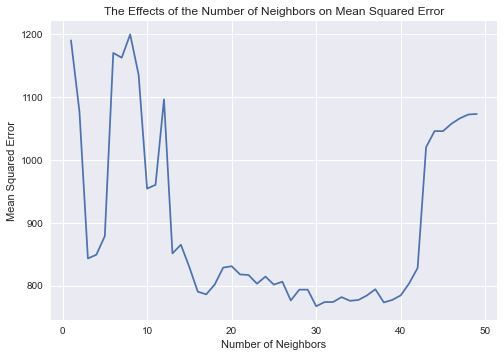

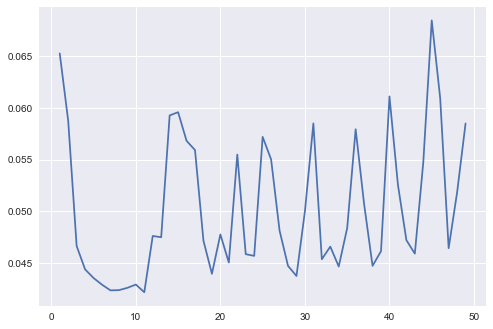

In [1970]:
# KNN using ball_tree algo
times = {}
num_neighbours = {}
for i in range(1,50):
    start_time = time.time()
    num_neighbours[i] = cross.cross_validate_regions(data, 5, neighbors.KNeighborsClassifier(n_neighbors=i, algorithm='ball_tree'))
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times)
lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of the Number of Neighbors on Mean Squared Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()


30
767.0890132090133
0.04368185997009277


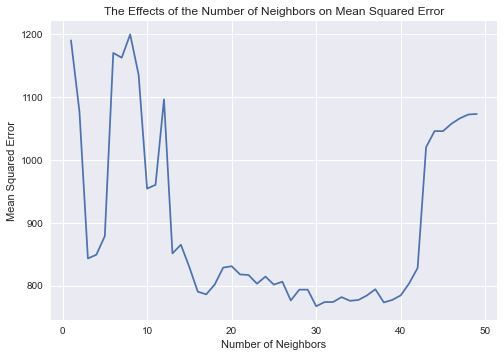

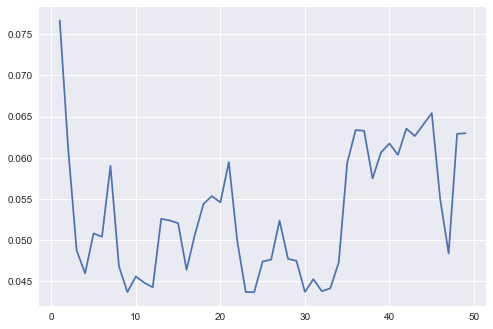

In [1971]:
# KNN using kd-tree algo
times = {}
num_neighbours = {}
for i in range(1,50):
    start_time = time.time()
    num_neighbours[i] = cross.cross_validate_regions(data, 5, neighbors.KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree'))
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times[m])

lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of the Number of Neighbors on Mean Squared Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()


In [1972]:
class TimeSeparator:
    def separate_at_date(self, data, date):
        data.drop(columns=["sub_region_1", "date_symptoms", "open_covid_region_code"], inplace=True)
        train = pd.DataFrame()
        test = pd.DataFrame()
        matched = data.loc[lambda data: data["date_hospitalization"] <= date]
        train = train.append(matched)
        matched = data.loc[lambda data: data["date_hospitalization"] > date]
        test = train.append(matched)
        test.drop(columns=["date_hospitalization"], inplace=True)
        train.drop(columns=["date_hospitalization"], inplace=True)
        return train, test


In [1973]:
ts = TimeSeparator()

1
843.9053923853924
0.09489202499389648


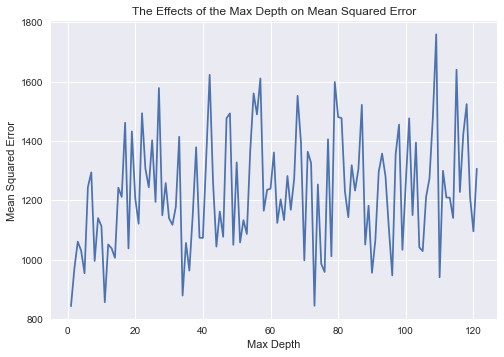

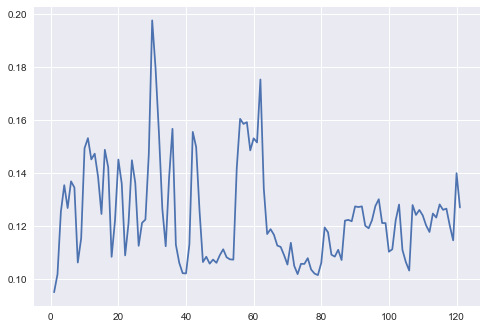

In [1974]:
times = {}
num_neighbours = {}

for i in range(1,122):
    start_time = time.time()
    num_neighbours[i] = cross.cross_validate_regions(data, 5, DecisionTreeClassifier(max_depth=i, criterion='entropy'))
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times[m])

lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of the Max Depth on Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()

52
1062.6179642579643
0.09879398345947266


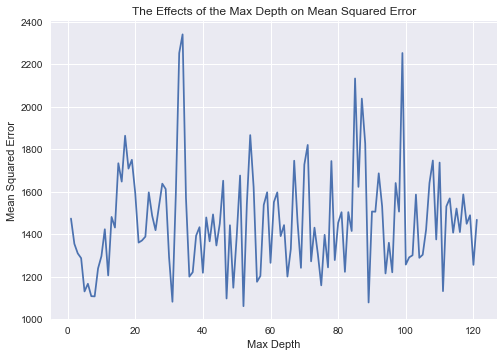

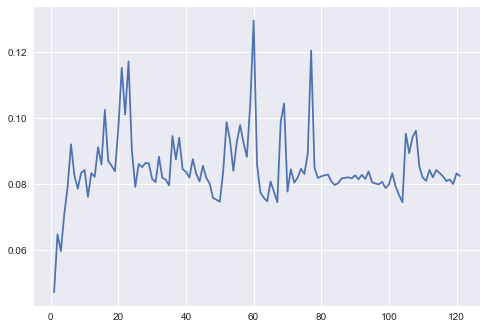

In [1975]:
times = {}
num_neighbours = {}

for i in range(1,122):
    start_time = time.time()
    num_neighbours[i] = cross.cross_validate_regions(data, 5, DecisionTreeClassifier(max_depth=i))
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times[m])

lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of the Max Depth on Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()

In [1976]:
# Date separated data
d = data.copy()
train, test = ts.separate_at_date(d, "2020-08-10")
x_train = train.loc[:,train.columns != "hospitalized_new"]
y_train = train.loc[:,train.columns == "hospitalized_new"]

x_test = test.loc[:,test.columns != "hospitalized_new"]
y_test = test.loc[:,test.columns == "hospitalized_new"]


In [1977]:
class Model_Runner:
    def run_model(self, model, xtrain, ytrain, xtest, ytest):
        model.fit(xtrain, ytrain)
        predictions = model.predict(xtest)
        return mean_squared_error(predictions, ytest)

runner = Model_Runner()

70
417.25409836065575
0.013979911804199219


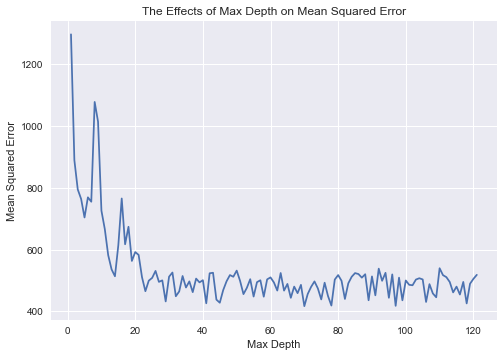

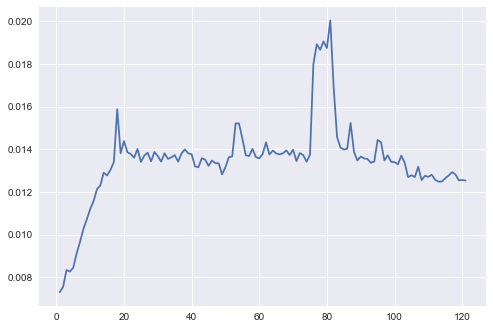

In [1978]:
times = {}
num_neighbours = {}

for i in range(1,122):
    start_time = time.time()
    num_neighbours[i] = runner.run_model(DecisionTreeClassifier(max_depth=i), x_train, y_train, x_test, y_test)
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times[m])

lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of Max Depth on Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()

104
243.9672131147541
0.01612997055053711


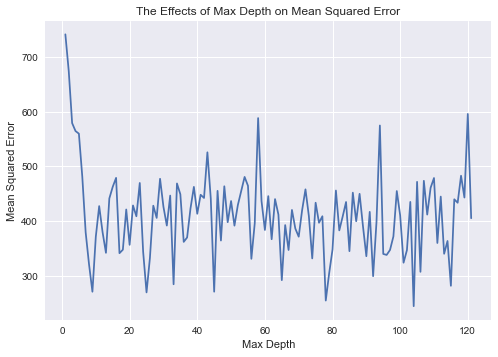

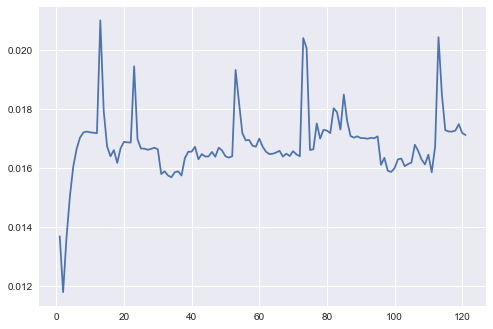

In [1979]:
times = {}
num_neighbours = {}

for i in range(1,122):
    start_time = time.time()
    num_neighbours[i] = runner.run_model(DecisionTreeClassifier(criterion="entropy", max_depth=i), x_train, y_train, x_test, y_test)
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times[m])
lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of Max Depth on Mean Squared Error')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()

1
398.4918032786885
0.010400056838989258


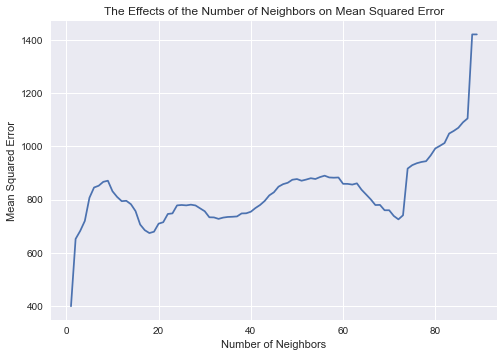

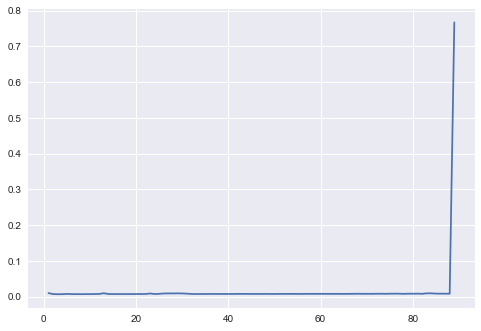

In [1980]:
# KNN using ball tree algo
times = {}
num_neighbours = {}
for i in range(1,90):
    start_time = time.time()
    num_neighbours[i] = runner.run_model(neighbors.KNeighborsClassifier(n_neighbors=i, algorithm="ball_tree"), x_train, y_train.values.ravel(), x_test, y_test)
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])
print (times[m])
for k in range(1,len(times.keys())):
    times[i] = times[i] + times[i-1] 
lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of the Number of Neighbors on Mean Squared Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()

1
398.4918032786885
0.009168148040771484


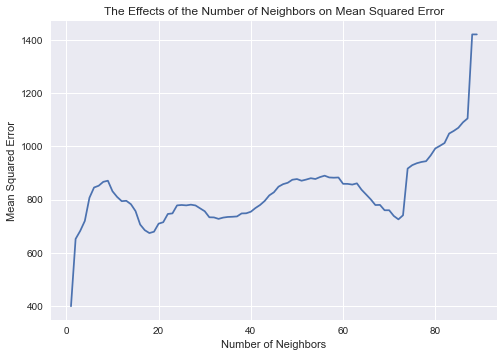

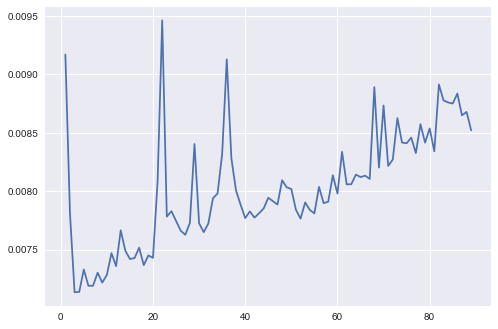

In [1981]:
# KNN using ball tree algo
times = {}
num_neighbours = {}
for i in range(1,90):
    start_time = time.time()
    num_neighbours[i] = runner.run_model(neighbors.KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree"), x_train, y_train.values.ravel(), x_test, y_test)
    times[i] = time.time() - start_time
m = min(num_neighbours.keys(), key=(lambda k: num_neighbours[k]))
print (m)
print (num_neighbours[m])

print(times[m])


lists = sorted(num_neighbours.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('The Effects of the Number of Neighbors on Mean Squared Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.show()

lists2 = sorted(times.items())
x2, y2 = zip(*lists2)
plt.plot(x2, y2)
plt.show()